# 시계열 탐색적 분석

## 일반적 EDA

<function matplotlib.pyplot.show(close=None, block=None)>

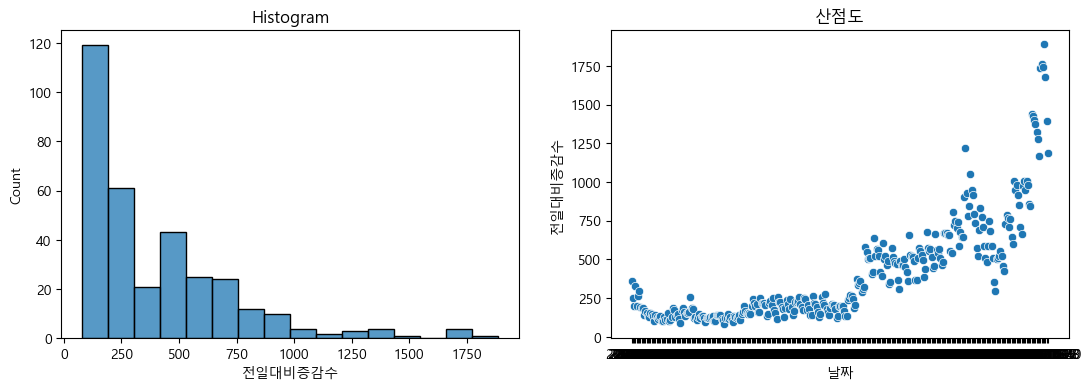

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pandas import read_csv

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

ts = read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/12_covid19.csv')
ts = ts.filter(['날짜', '전일대비증감수'])
ts = ts.set_index('날짜')
ts_head = ts.head(334)

fig, axes = plt.subplots(1, 2, figsize=(13,4))

axes[0].set_title('Histogram')
sns.histplot(x='전일대비증감수', data=ts_head, ax=axes[0])

axes[1].set_title('산점도')
sns.scatterplot(x='날짜', y='전일대비증감수', data=ts_head, ax=axes[1])
plt.show

## 시계열 특화 EDA

### 정상성 확인
- 정상성
    - 시간 흐름과 무관하게 평균과 분산이 일정하고 추세나 계절성을 갖지 않는다.
- 정상성 측도
    - ADF(Augmented Dickey-Fuller) 검정
        - 귀무가설('단위근이 있다')와 대립가설('단위근이 없다')로 검정.
        - 단위근이 없어야 정상성 만족 
    - KPSS(Kwiatowski-Philips-Schmidt-Shin) 검정
        - 귀무가설('정상 시계열이다')와 대립가설('비정상 시계열이다')로 검정.
        - 단위근이 없어야 정상성 만족 
    - ACF 그래프
        - 시차가 증가할수록 0으로 빠르게 감소
        - 비정상성 데이터는 느리게 감소
- 정상화 방법
    - 평균이 일정하지 않은 경우는 데이터를 차분(differencing)
    - 분산이 변환하는 경우는 데이터를 변환(transformation)
        - 로그 변환
        - 제곱근 변환
        - Box-cox 변환
        - Yeo-Johnson 변환

ADF Statistics: 0.762, p-value: 0.991
KPSS Statistics: 2.210, p-value: 0.010


C:\Users\lsel\AppData\Local\Temp\ipykernel_19604\877368025.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(ts_head, regression='c', nlags='auto')
C:\Users\lsel\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


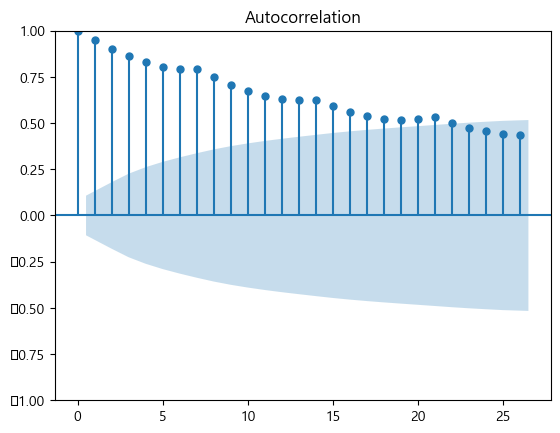

In [19]:
# ADF(Augmented Dickey-Fuller) 검정
#   귀무가설('단위근이 있다')와 대립가설('단위근이 없다')로 검정.
#       p-value가 0.05보다 작으면 대립가설, 단위근이 없다, 즉 정상 시계열로 본다.   
#   단위근이 없어야 정상성 만족 

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf

result = adfuller(ts_head, regression='c', autolag='AIC')
print('ADF Statistics: {:.3f}, p-value: {:.3f}'.format(result[0], result[1]))


# KPSS(Kwiatowski-Philips-Schmidt-Shin) 검정
#   귀무가설('정상 시계열이다')와 대립가설('비정상 시계열이다')로 검정.
#       p-value가 0.05보다 작으면 대립가설, 즉 비정상 시계열로 본다.
#   단위근이 없어야 정상성 만족 
result = kpss(ts_head, regression='c', nlags='auto')
print('KPSS Statistics: {:.3f}, p-value: {:.3f}'.format(result[0], result[1]))


# ACF 그래프
#   값이 빠르게 떨어지면 정상성. 완만하게 떨어지면 비정상성
plot_acf(ts_head)
plt.show()

### 자기상관 확인
- 자기상관 (Autocorrelation)
    - 서로 다른 시점의 데이터 간 선형적 상관관계
- 자기상관 측도
    - 자기상관함수(Auto-correlation Funtion) 사용
        - x축은 시차, y축 자기상관계수
        - 임계치를 넘는다면 자기상관
    - 편자기상관함수 (Partial auto-correlation Function)
        - k 이외 모든 시점 관측치의 영향력을 배제하고 Yt와 Yt-k의 관련성 측정
    - 융-박스 검정
        - 귀무가설('자기상관이 없다')
    - 더빈왓슨 검정
        - 2에 가까울수록 자기상관 없고, 0에 가까울수록 자기상관

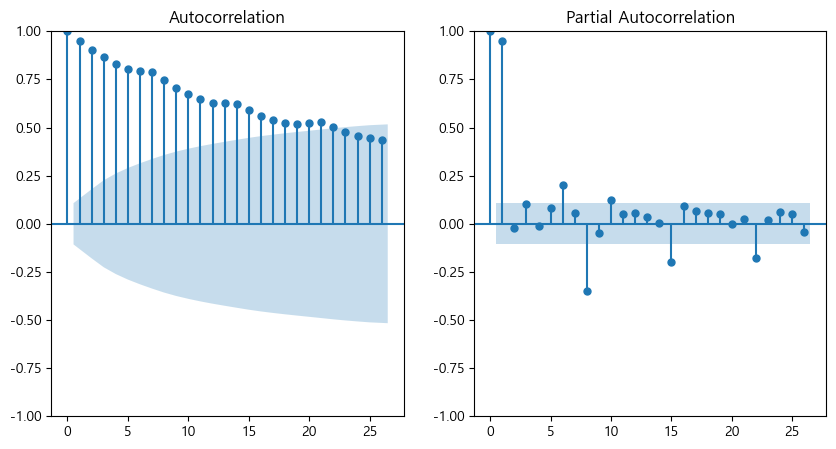

0시차: 자기상관계수 1.000, 신뢰구간 1.000 ~ 1.000
1시차: 자기상관계수 0.954, 신뢰구간 0.846 ~ 1.061
2시차: 자기상관계수 0.907, 신뢰구간 0.727 ~ 1.087
3시차: 자기상관계수 0.873, 신뢰구간 0.646 ~ 1.100


In [26]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plot_acf(ts_head, ax=axes[0])
plot_pacf(ts_head, ax=axes[1])
plt.show()

# ACF 그래프의 임계영역을 벗어나는 값들을 볼 때 자기상관이 있음을 파악
# PACF 그래프에서 lag 1, 3, 6, 8 등에서 자기상관을 암시하고 있음.

ACs, confs = acf(ts_head, fft=False, nlags=3, alpha=0.05, adjusted=True)
for lag, ac, conf in zip(range(3+1), ACs, confs):
    print(f'{lag}시차: 자기상관계수 {ac:.3f}, 신뢰구간 {conf[0]:.3f} ~ {conf[1]:.3f}')


### 시계열 분해
- 시계열 분해 시 요소
    - 추세 (trend variation)
    - 계절성 (seasonal variation)
    - 주기 (cycle variation)
    - 불규칙변동 (irregular variation)
- 시계열 분해 방법
    - 이동평균법
        - 불규칙변동과 계절변동 제거. 추세변동과 순환변동만 남김
    - 지수평활법
        - 불규칙변동 제거
        - 모든 데이터의 평균 활용. 최근 시계열에 가중치
    - STL 분해

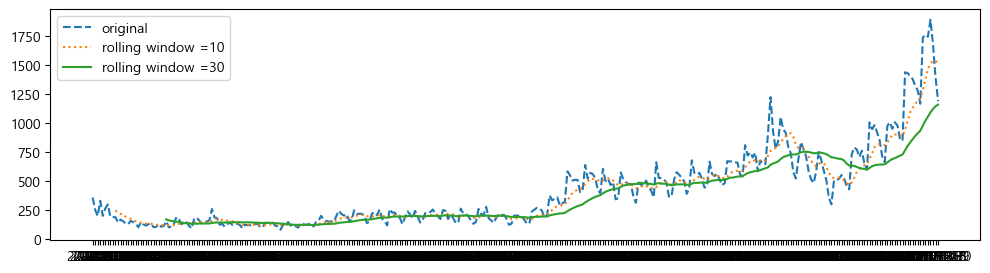

In [30]:
# 이동평균법 : 불규칙변동, 계절변동 제거
fig, ax = plt.subplots(1,1, figsize=(12,3))

titles=['original', 'rolling window =10', 'rolling window =30']
rw10 = ts_head.rolling(window=10).mean().dropna()
rw30 = ts_head.rolling(window=30).mean().dropna()
data_list = [ts_head, rw10, rw30]
ls_list = ['dashed', 'dotted', 'solid']

for title, data, ls in zip(titles, data_list, ls_list):
    ax.plot(data, label=title, linestyle=ls)
plt.legend()
plt.show()

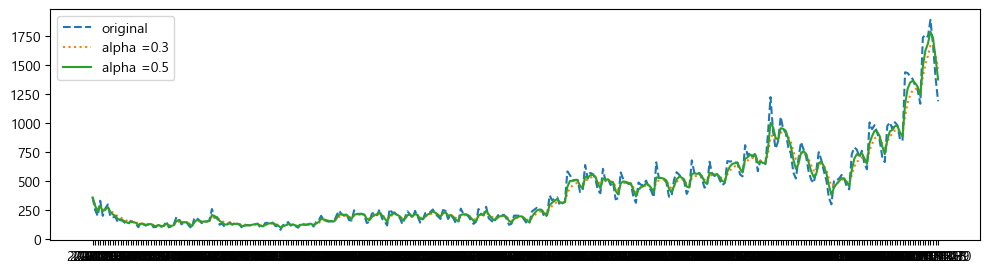

In [32]:
# 지수평활법 : 불규칙변동만 제거
fig, ax = plt.subplots(1,1, figsize=(12,3))

titles=['original', 'alpha =0.3', 'alpha =0.5']
ewm03 = ts_head.ewm(alpha=0.3).mean()
ewm05 = ts_head.ewm(alpha=0.5).mean()
data_list = [ts_head, ewm03, ewm05]
ls_list = ['dashed', 'dotted', 'solid']

for title, data, ls in zip(titles, data_list, ls_list):
    ax.plot(data, label=title, linestyle=ls)
plt.legend()
plt.show()

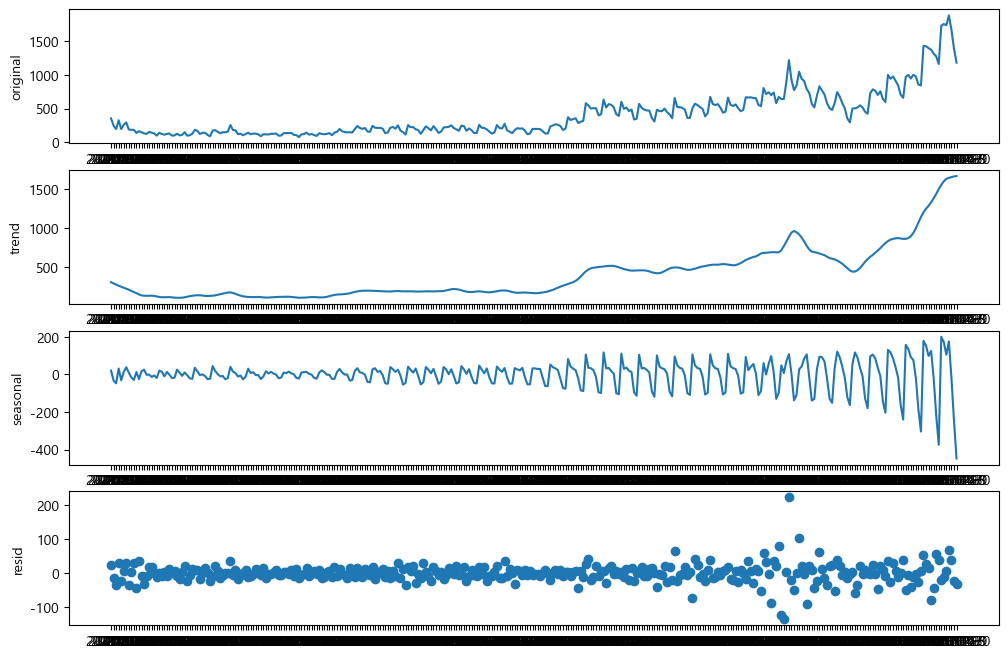

In [37]:
# STL분해

from statsmodels.tsa.seasonal import STL

# seasonal : Length of the seasonal smoother
# trend : Length of the trend smoother
fitted = STL(ts_head, seasonal=7, trend=9, period=7).fit()

resid = fitted.resid        # 잔차
seasonal = fitted.seasonal  # 추정된 계절요소
trend = fitted.trend        # 추정된 트렌드요소

titles=['original', 'trend', 'seasonal', 'resid']
data_list = [ts_head, trend, seasonal, resid]

fig, axes = plt.subplots(4, 1, figsize=(12, 8))
for title, data, ax in zip(titles, data_list, axes):
    ax.set_ylabel(title)
    if title != 'resid':
        ax.plot(data)
    else:
        ax.scatter(x=data.index, y=data.values)
plt.show()

# 시계열 데이터 전처리


- 시계열 데이터 전처리 유형
    - object, string, timestamp --> datetime 형식으로 변환 
    - 날짜/시간 데이터 생성
    - 날짜/시간 데이터 값 변경
    - 날짜/시간 데이터 연산
    - 날짜/시간 데이터에서 인덱스 추출하기

In [2]:
import time
import datetime as dt
import pandas as pd

ts = pd.read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/12_covid19.csv')


# object -> datetime 변환
ts['날짜'] = ts['날짜'].astype('datetime64[ns]')

In [22]:
# string - datetime 상호 변환 ===================================
string = '2018-09-13 22:39:04'

dtobj = dt.datetime.strptime(string, '%Y-%m-%d %H:%M:%S')
print('string to datetime: ', type(dtobj))

string2 = dtobj.strftime('%Y-%m-%d %H:%M:%S')
print('datetime to string: ', type(string2))


# timestamp - datetime 변환 ===================================
timestamp = 2551780740
dtobj = dt.datetime.fromtimestamp(timestamp)
dtobj_utc = dt.datetime.utcfromtimestamp(timestamp)
timestamp2 = time.mktime(dtobj.timetuple())

print('timestamp to local datetime', dtobj)
print('timestamp to utc datetime', dtobj_utc)
print('timestamp from datetime', timestamp2)


# 날짜 데이터 생성하기 ===================================
dtobj1 = dt.datetime(2023, 3, 20, 11, 3, 3)
dtobj2 = dt.datetime.now()

date_only = dt.date(2023, 3, 20)
time_only = dt.time(11, 3, 3)
dtobj3 = dt.datetime.combine(date_only, time_only)

print(dtobj1, dtobj2, dtobj3)
print(date_only, time_only)


# 날짜 데이터 리스트 생성하기 ===================================

#freq = {A(연), M(월), D(일), T(분), S(초), Q(분기), W(주)}
datelist1 = pd.date_range('2016-01-01', periods=3, freq='D')
datelist2 = pd.date_range('2016-01-01', periods=4, freq='W')
datelist3 = pd.date_range('2016-01-01', '2016-01-02', freq='30T')
print('datetime 객체 : 1일 간격 3개 생성\n', datelist1)
print('datetime 객체 : 1주 간격 4개 생성\n', datelist2)
print('datetime 객체 : 30분 간격 기간 지정 생성\n', datelist3)

datelist4 = pd.period_range('2016-01-01', periods=2, freq='A')
datelist5 = pd.period_range('2016-01-01', periods=3, freq='Q')
print('period 객체 : 연단위 2개 생성\n', datelist4)
print('period 객체 : 분기단위 3개 생성\n', datelist5)


# 날짜/시간 간 연산하기 ===================================

week1 = dt.timedelta(weeks=1)
today = dt.datetime.now()

print('delta {}, type{}'.format(week1, type(week1)))
print('1주 전 날짜', today-week1)
print('1주 후 날짜', today+week1)


# 날짜/시간 열에서 특정 인덱스만 추출 ===================================
ts['년'] = ts.날짜.dt.year
ts['월'] = ts.날짜.dt.month
ts['일'] = ts.날짜.dt.day
ts['요일1'] = ts.날짜.dt.weekday
ts['요일2'] = ts.날짜.dt.day_name()


# Down sampling ===================================
#freq = {A(연), M(월), D(일), T(분), S(초), Q(분기), W(주)}

# 원하는 기간 별 대표 날짜의 데이터를 반환
print('분기 down sampling \n', ts.resample(rule='Q').asfreq())

# 원하는 기간 별 데이터의 합을 반환
print('\n\n분기별 데이터 합계 \n', ts.resample(rule='Q').sum())

# 원하는 기간 별 데이터의 평균 반환
print('\n\n분기별 데이터 평균 \n', ts.resample(rule='Q').mean())

string to datetime:  <class 'datetime.datetime'>
datetime to string:  <class 'str'>
timestamp to local datetime 2050-11-11 20:59:00
timestamp to utc datetime 2050-11-11 11:59:00
timestamp from datetime 2551780740.0
2023-03-20 11:03:03 2024-09-28 21:41:10.348446 2023-03-20 11:03:03
2023-03-20 11:03:03
datetime 객체 : 1일 간격 3개 생성
 DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03'], dtype='datetime64[ns]', freq='D')
datetime 객체 : 1주 간격 4개 생성
 DatetimeIndex(['2016-01-03', '2016-01-10', '2016-01-17', '2016-01-24'], dtype='datetime64[ns]', freq='W-SUN')
datetime 객체 : 30분 간격 기간 지정 생성
 DatetimeIndex(['2016-01-01 00:00:00', '2016-01-01 00:30:00',
               '2016-01-01 01:00:00', '2016-01-01 01:30:00',
               '2016-01-01 02:00:00', '2016-01-01 02:30:00',
               '2016-01-01 03:00:00', '2016-01-01 03:30:00',
               '2016-01-01 04:00:00', '2016-01-01 04:30:00',
               '2016-01-01 05:00:00', '2016-01-01 05:30:00',
               '2016-01-01 06:00:00', '2016-0

- 시계열 데이터 결측치 처리
    - forward fill
        - 바로 이전 데이터로 채우기
    - backward fill
        - 바로 다음 데이터로 채우기
    - 이동평균 (Moving average)
        - 지난 데이터의 평균. 일종의 forward fill
        - 단순 산술평균 외에, 지수가중이동평균(exponentially weighted moving average)
    - 보간법 (Interpolation) : Pandas.interpolate
        - 선형보간법
        - 2차 스플라인(Quadratic spline) 보간법
        - 3차 스플라인(Cubic spline) 보간법
        - 다항식(polynomial) 보간법

In [17]:
# 시계열 빈도 변경 (다운 샘플링)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
ts = pd.read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/12_covid19.csv')

ts.날짜 = ts.날짜.astype('datetime64[ns]')
ts = ts.set_index('날짜')
ts_na = ts.copy()

rand_numbers = np.random.randint(0, len(ts)-1, 50)
for num in rand_numbers:
    ts_na.iloc[num, :] = np.nan

ts_na.isna().sum()

누적확진자수     45
전일대비증감수    45
dtype: int64

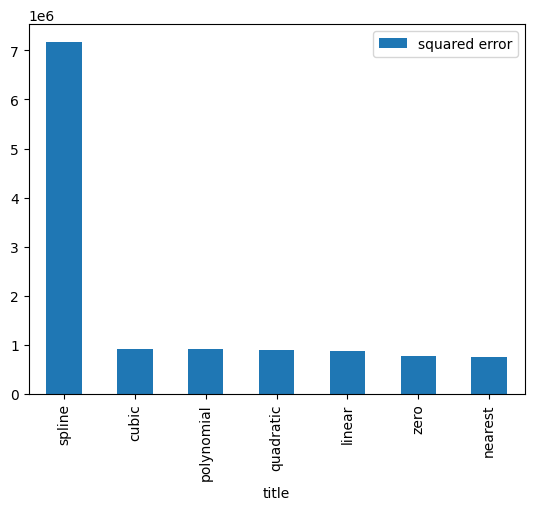

In [18]:
#각종 보간 후, 실제 데이터와 비교
linear= ts_na.interpolate(method='linear')
nearest= ts_na.interpolate(method='nearest')
zero= ts_na.interpolate(method='zero')
quadratic= ts_na.interpolate(method='quadratic')    #'polynomial order=2와 동일
cubic= ts_na.interpolate(method='cubic')    #'polynomial order=3과 동일
spline= ts_na.interpolate(method='spline', order=2)
polynomial= ts_na.interpolate(method='polynomial', order=3)

titles = ['linear', 'nearest', 'zero', 'quadratic', 'cubic', 'spline', 'polynomial']
datalist = [linear, nearest, zero, quadratic, cubic, spline, polynomial]
sqrd_err = []

for title, data in zip(titles, datalist):
    sqrd_e = sum((ts-data)['전일대비증감수']**2)
    sqrd_err.append(int(sqrd_e))

result = pd.DataFrame({'title':titles, 'error':sqrd_err}).sort_values(by='error', ascending=False)

result.plot.bar(x='title', y='error', label='squared error')
plt.show()

- 차분과 변환
    - 탐색적 분석 단계에서 시계열 데이터가 정상성을 갖지 않는 것으로 확인된 경우
    - 차분과 변환을 통해 데이터 전처리 필요

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
ts = pd.read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/12_covid19.csv')

ts = ts.filter(['날짜', '전일대비증감수'])
ts.날짜 = ts.날짜.astype('datetime64[ns]')
ts = ts.set_index('날짜')

ts_head = ts.head(334)
ts_tail = ts.tail(31)

C:\Users\lsel\AppData\Local\Temp\ipykernel_20584\1193440112.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kp = kpss(data)[1]
C:\Users\lsel\AppData\Local\Temp\ipykernel_20584\1193440112.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kp = kpss(data)[1]
C:\Users\lsel\AppData\Local\Temp\ipykernel_20584\1193440112.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kp = kpss(data)[1]


original: ADF p-value 0.991, KPSS p-value 0.010
diff(1): ADF p-value 0.004, KPSS p-value 0.100
diff(2): ADF p-value 0.005, KPSS p-value 0.100


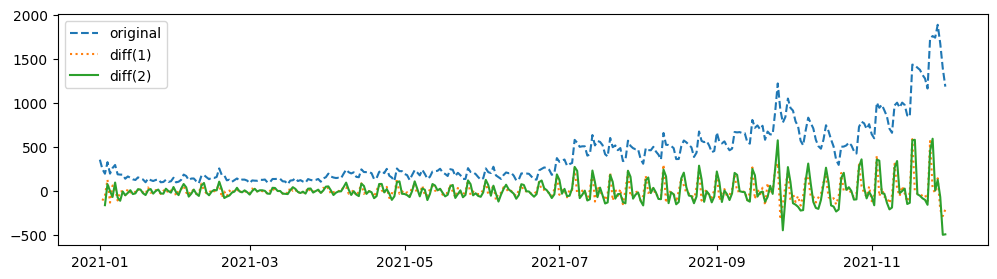

In [3]:
#차분 전후 비교
from statsmodels.tsa.stattools import adfuller, kpss
fig, ax = plt.subplots(1,1, figsize=(12, 3))

titles=['original', 'diff(1)', 'diff(2)']

diff1 = ts_head.diff(periods=1).dropna()
diff2 = ts_head.diff(periods=2).dropna()
datalist = [ts_head, diff1, diff2]
ls_list = ['dashed', 'dotted', 'solid']

for title, data, ls in zip(titles, datalist, ls_list):
    ax.plot(data, label=title, linestyle=ls)
    ap = adfuller(data)[1]
    kp = kpss(data)[1]
    print('{}: ADF p-value {:.3f}, KPSS p-value {:.3f}'.format(title, ap, kp))
plt.legend()
plt.show()

# 1번의 차분으로 정상시계열이 되었다.

original: ADF p-value 0.991, KPSS p-value 0.010
log: ADF p-value 0.001, KPSS p-value 0.100
box-cox: ADF p-value 0.000, KPSS p-value 0.100


C:\Users\lsel\AppData\Local\Temp\ipykernel_20584\2744856793.py:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kp = kpss(data)[1]
C:\Users\lsel\AppData\Local\Temp\ipykernel_20584\2744856793.py:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kp = kpss(data)[1]
C:\Users\lsel\AppData\Local\Temp\ipykernel_20584\2744856793.py:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kp = kpss(data)[1]


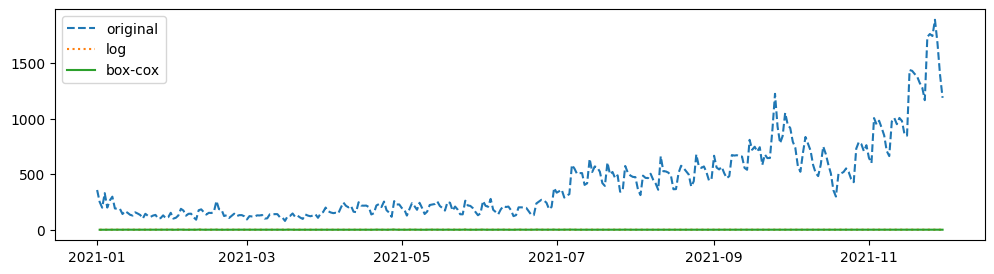

In [4]:
# 변환과 차분 전후 비교
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.preprocessing import PowerTransformer
import numpy as np

# 로그변환
log = np.log(ts_head)

# 박스콕스 변환
pt = PowerTransformer(method='box-cox')
rescaled = pt.fit_transform(ts_head)
boxcox = pd.DataFrame(rescaled, index=ts_head.index, columns=ts_head.columns)

# 차분1회
log = log.diff(1).dropna()
boxcox = boxcox.diff(1).dropna()

# 시각화
titles = ['original','log','box-cox']
datalist = [ts_head, log, boxcox]
lslist = ['dashed', 'dotted', 'solid']

fig, ax = plt.subplots(1,1, figsize=(12, 3))
for title, data, ls in zip(titles, datalist, lslist):
    ax.plot(data, label=title, linestyle=ls)
    ap = adfuller(data)[1]
    kp = kpss(data)[1]
    print('{}: ADF p-value {:.3f}, KPSS p-value {:.3f}'.format(title, ap, kp))
plt.legend()
plt.show()

C:\Users\lsel\AppData\Local\Temp\ipykernel_8988\2815488205.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kp = kpss(data)[1]
C:\Users\lsel\AppData\Local\Temp\ipykernel_8988\2815488205.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kp = kpss(data)[1]


log: ADF p-value 0.001, KPSS p-value 0.100
box-cox: ADF p-value 0.000, KPSS p-value 0.100


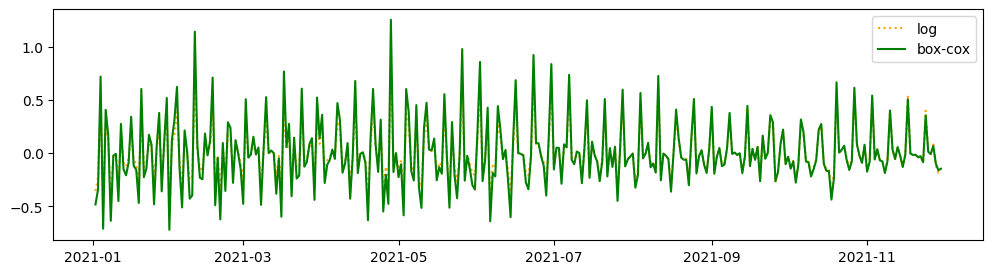

In [36]:
titles = ['log','box-cox']
datalist = [log, boxcox]
lslist, clist = ['dotted', 'solid'], ['orange', 'green']
fig, ax = plt.subplots(1,1, figsize=(12, 3))
for title, data, ls, c in zip(titles, datalist, lslist, clist):
    ax.plot(data, label=title, linestyle=ls, color=c)
    ap = adfuller(data)[1]
    kp = kpss(data)[1]
    print('{}: ADF p-value {:.3f}, KPSS p-value {:.3f}'.format(title, ap, kp))
plt.legend()
plt.show()

# 시계열 모델링 및 평가

### 개념
- 자기회귀 (AR, Auto Regressive) 모델
    - n번째 데이터는 1~n-1번 데이터에 가중치를 곱함으로써 구할 수 있다.
- 이동평균 (MA, Moving Average) 모델
    - n번째 데이터는 1~n-1번의 오차항에 가중치를 곱합으로써 구할 수 있다.
    - MA(1)이면 현재 오차항에 직전 오차항 사용
- 자기회귀 이동평균 (ARMA, Auto Regressive Moving Average) 모델 
    - AR(p)모델과 MA(q)모델을 더한 것
- 자기회귀 누적 이동평균 (ARIMA, Auto Regressive Integrated Moving Average) 모델 
    - d회 차분 후 AR(p)모델과 MA(q)모델을 더한 것
    - ARIMA(p, d, q)로 표현함.
- 계절성 ARIMA 모델

### Box-Jenkins와 ARIMA
- 정상성과 계절성 확인
- 정상성을 위한 차분과 변환 진행
- 적절한 차수 p와 q찾기 (ACF / PACF 그래프 활용)
    - AR(p)는 ACF 값이 천천히 감소, PACF값은 p 이후에 빠르게 감소
        - AR(p)는 PACF에서 마지막으로 절단선에 걸린 lag로 정한다.
    - MA(q)는 ACF 값이 q이후 빠르게 감소, PACF에서 천천히 감소
        - MA(q)는 ACF에서 마지막으로 절단선에 걸린 lag으로 정한다.
- 모델 검정에는 잔차의 정상성(Ljung-Box), 등분산성(Heteroskedasticity), 정규성(JB) 검정을 포함한다.
    - 정상성. Ljung-Box (Q), 
        - 귀무가설 : 잔차가 백색잡음이다. 즉 p-value는 0.05보다 커야 함.
    - 등분산성. Heteroskedasticity (H), 
        - 귀무가설 : 잔차가 등분산성을 갖는다. 즉 p-value는 0.05보다 커야 함.
    - 정규성. Jarque-Bera (JB)
        - 귀무가설 : 정규성을 만족한다. 즉 p-value는 0.05보다 커야 함.

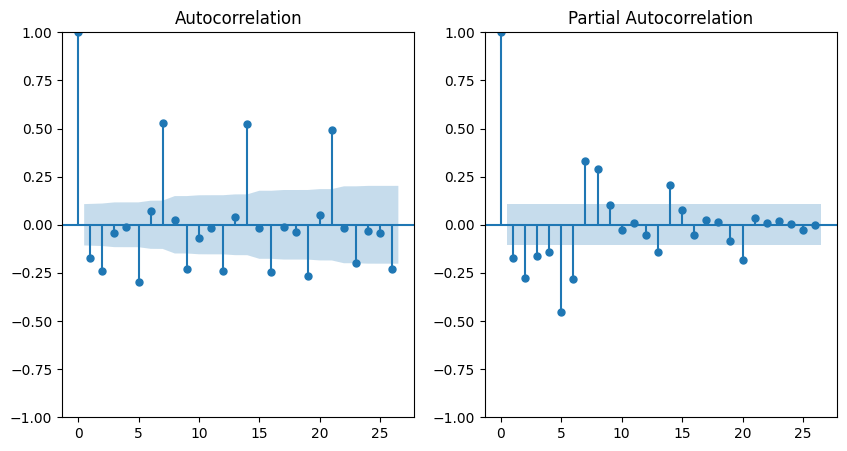

In [7]:
# Box-Jenkins 방법
#   boxcox 변환 및 차분을 통해 정상화
#   boxcox로 적절한 차수 찾기

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import PowerTransformer
import numpy as np

# 박스콕스 변환
pt = PowerTransformer(method='box-cox')
rescaled = pt.fit_transform(ts_head)
boxcox = pd.DataFrame(rescaled, index=ts_head.index, columns=ts_head.columns)

# 차분1회
boxcox = boxcox.diff(1).dropna()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_acf(boxcox, ax=ax[0])
plot_pacf(boxcox, ax=ax[1])
plt.show()

## 차수는 plot 상의 절단선을 참고하여 p=9, q=2로 정하여 모델을 적합하기로 한다.

# 모델의 계절성
p = 9   #AR 차수
d = 1   #차분 회수
q = 2   #MA 차수

# 모델의 비계절성
P = 0
D = 0
Q = 1   # PACF가 지수적으로 감소할 때 1로 설정
s = 7   # ACF에서 lag7마다 뾰족한 막대. 계절성 단위는 7이 된다.

In [10]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ARIMA에서 seasonal_order를 입력하면 SARIMAX와 동일한 결과
model = ARIMA(ts_head, order=(p,d,q), seasonal_order=(P,D,Q,s))
fitted = model.fit()
resid = fitted.resid

# pred1과 pred2는 동일한 값임
pred1 = fitted.forecast(31) #이후 31개 날짜의 값을 예측
pred2 = fitted.predict(start=ts_tail.index[0], end=ts_tail.index[-1]) #이후 31일치의 날짜를 주고 예측

fitted.summary()

# 결과 상 잔차 검정 시 정규성과 등분산성이 만족되지 않는다. 모델 개선이 필요하다.

c:\Users\lsel\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lsel\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lsel\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lsel\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                           전일대비증감수   No. Observations:                  334
Model:             ARIMA(9, 1, 2)x(0, 0, [1], 7)   Log Likelihood               -1854.018
Date:                           Thu, 03 Oct 2024   AIC                           3734.036
Time:                                   22:57:59   BIC                           3783.542
Sample:                               01-01-2021   HQIC                          3753.777
                                    - 11-30-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0278      1.000     -0.028      0.978      -1.988       1.932
ar.L2         -0.1716      0.495     -0.346      0.729      -1.143       0.799
ar.L3         -0.0262      0.029     -0.915      0.360      -0.082       0.030
ar.L4         -0.0401      0.038     -1.067      0.286      -0.114       0.034
ar.L5         -0.0380      0.033     -1.152      0.249      -0.103       0.027
ar.L6         -0.0319      0.031     -1.024      0.306      -0.093       0.029
ar.L7          0.9458      0.040     23.488      0.000       0.867       1.025
ar.L8          0.0042      0.973      0.004      0.997      -1.902       1.910
ar.L9          0.1369      0.475      0.288      0.773      -0.794       1.068
ma.L1         -0.2072      0.993     -0.209      0.835      -2.154       1.739
ma.L2          0.0485      0.705      0.069      0.945      -1.333       1.430
ma.S.L7       -0.6529      0.059    -11.157      0.000      -0.768      -0.538
sigma2      4657.0868    268.211     17.364      0.000    4131.402    5182.771
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1187.41
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               8.50   Skew:                             1.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 자동 차수 선택방법과 ARIMA
- 여러 조합의 차수들을 적용하여 적합한 모델을 찾는다.
    - 적합성의 판단 기준은 가능도는 가장 높고 AIC값는 가장 낮은 것.
    - pmdarima 패키지의 auto_arima 사용하거나 반복문 코딩

In [14]:
#자동 차수 선택방법 1. auto_arima
from pmdarima import auto_arima

auto_arima(ts_head, 
           start_p=1,
           start_q=1,
           max_p=5,
           max_q=5,
           start_P=0,
           start_Q=0,
           max_P=5,
           max_Q=5,
           m=7,seasonal=True,
           trace=False,
           error_action='warn',
           suppress_warnings=True)

ARIMA(order=(3, 1, 0), scoring_args={}, seasonal_order=(1, 0, 1, 7),
      suppress_warnings=True, with_intercept=False)

In [15]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(ts_head, order=(3,1,0), seasonal_order=(1,0,1,7))
fitted = model.fit()
resid = fitted.resid
pred3 = fitted.forecast(31)
pred4 = fitted.predict(start=ts_tail.index[0], end=ts_tail.index[-1])

fitted.summary()

# 결과상 여전히 정규성과 등분산성이 만족되지 않는다.

c:\Users\lsel\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lsel\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lsel\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lsel\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                           전일대비증감수   No. Observations:                  334
Model:             ARIMA(3, 1, 0)x(1, 0, [1], 7)   Log Likelihood               -1852.753
Date:                           Thu, 03 Oct 2024   AIC                           3717.507
Time:                                   23:57:54   BIC                           3740.355
Sample:                               01-01-2021   HQIC                          3726.618
                                    - 11-30-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2260      0.036     -6.292      0.000      -0.296      -0.156
ar.L2         -0.1731      0.039     -4.395      0.000      -0.250      -0.096
ar.L3         -0.1133      0.042     -2.691      0.007      -0.196      -0.031
ar.S.L7        0.9825      0.015     66.326      0.000       0.953       1.012
ma.S.L7       -0.6567      0.040    -16.420      0.000      -0.735      -0.578
sigma2      3830.1968    168.182     22.774      0.000    3500.566    4159.828
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               918.21
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               8.14   Skew:                             0.93
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#자동 차수 선택방법 2. 반복문 사용